In [1]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

import numpy as np
import matplotlib.pyplot as plt

import json
import IPython.display
import IPython.display as ipd

from radiomixer.sampler.filesampler import FileSampler
from radiomixer.io.loader.loaders import ClassicLoader, TIMITLoader
from radiomixer.config.configloader import create_config_loader
from radiomixer.creator.transformchaincreator import TransformsChainCreator
from radiomixer.creator.transformfacory import TransformFactory

from radiomixer.transforms.mixer.mixers import CustomMixer



def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))




from radiomixer.io.saver.savers import WaveFeaturesSaver
def init(configs):
    print(configs)
    loader_types = {
            "ClassicLoader": ClassicLoader,
            "TIMITLoader": TIMITLoader,
            }
    saver_types = {
            "WaveFeaturesSaver": WaveFeaturesSaver
            }
    fileSampler = FileSampler(configs=configs["FileSampler"])

    loader_module = loader_types.get(configs["FileLoader"]["type"])
    loader = loader_module(cfg = configs["FileLoader"]["configs"]) 
    
    transform_factory = TransformFactory()
    transforms_chain_creator = TransformsChainCreator(transform_factory)

    transforms_chain = transforms_chain_creator.create(configs["transform_chain"])
    

    return fileSampler, loader, transforms_chain

def preprocess(fileSampler, loader, transforms_chain):
    file_paths, dataset_names = fileSampler.sample_files()
    signals = loader.seq_load(file_paths, dataset_names)
    signals = transforms_chain.process(signals)
    return signals

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



{'FileLoader': {'type': 'TIMITLoader', 'configs': {'sample_rate': 16000, 'remove_silence': False, 'normalize': True, 'min_duration': 4}}, 'FileSaver': {'type': 'WaveFeaturesSaver', 'configs': {}}, 'SequentialFileProcessor': {'num_files_generate': 3, 'save_dir': '../Datasets/teamplate', 'save_config_dir': '../Datasets/teamplate'}, 'FileSampler': {'dataset_split': 'train', 'test_size': 0.001, 'dataset_dirs': ['/home/lev/radiomixer/Datasets/ToyTIMIT/TRAIN', '/home/lev/radiomixer/Datasets/ToyTIMIT/TRAIN'], 'dataset_names': ['speech1', 'speech2'], 'min_datasets': 2, 'dataset_prob': [0.5, 0.5], 'replace': False, 'seed': 42}, 'transform_chain': {'EqualSegmentSampler': {'sampling_rate': 16000, 'final_audio_clip_duration': 4}, 'TransitionOverlapedSegmentsParametersSampler': {'max_fade_in': 0.45, 'min_fade_in': 0.1, 'max_fade_out': 0.45, 'min_fade_out': 0.1, 'max_stable_period': 0.1, 'in_transition_type': ['linear', 'logarithmic', 'exponential', 'half_sine'], 'out_transition_type': ['linear', 'l

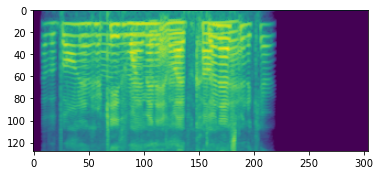

AUDIO 1


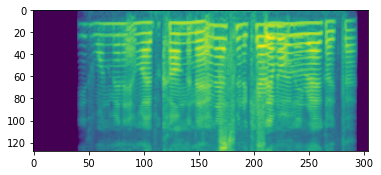

In [19]:
config_file = '/home/lev/radiomixer/configs/teamplate2.yaml'
config_loader = create_config_loader()
configs = config_loader.load(config_file)
fileSampler, loader, transforms_chain = init(configs)



for i in range(2):
    signal = preprocess(fileSampler, loader, transforms_chain)
    print(f'AUDIO {i}')
    plt.plot(signal.data[0])
    plt.imshow(signal.data_features[0])
    ipd.display(Audio(signal.data[0], signal.sample_rate))
    plt.show()